# HANDWRITTEN REGCONITION USING CNN + LSTM

## IMPORT LIBRARIES

In [51]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import tensorflow.keras.backend as K

# make sure we use tensorflow 2.0
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

# import padding library
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import our model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import pathlib
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/home/jupyter/fed/HTR'

## CREATE PATH FOR IMAGES AND VISUALIZE SOME EXAMPLE

In [52]:
data_train = '../HTR/raw/train'
data_test = '../HTR/raw/test'
# data_train = '/home/jupyter/fed/HTR/data/train'
# data_test = '/home/jupyter/fed/HTR/data/test'

In [53]:
train_image_paths = list(pathlib.Path(data_train).glob("**/*.png"))
test_image_paths = list(pathlib.Path(data_test).glob("**/*.png"))

In [56]:
def show_batch(image_batch):
    '''Show batch of 4 images.
    
    Parameters:
        image_batch: paths to the images, len(image_path) >= 4
        label_batch: labels of the images (str)
    '''
    plt.figure(figsize=(100,100))



    plt.imshow(cv2.imread(str(image_batch)))
    plt.axis('off')

## LOAD JSON LABEL FILES

In [59]:
# import json
# with open("../HTR/raw/train/labels.json", encoding="utf8") as json_file:
#     train_labels = json.load(json_file)
with open("../HTR/raw/test/labels.json", encoding="utf8") as json_file:
    test_labels = json.load(json_file)

In [60]:
# Define unique char list
char = []
for item in train_labels:
    for i in train_labels[item]:
        if i not in char:
            char.append(i)
for item in test_labels:
    for i in test_labels[item]:
        if i not in char:
            char.append(i)

In [64]:
len(char)

148

In [63]:
# Missing some letters.just fill and sort it
char = char + ['ÁÃÀẢẤẠ']
char = ''.join(sorted(char))

In [65]:
# Create function encode label
def encode_to_labels(txt):
    # encoding each output word into digits of indexes
    dig_lst = []
    for index, chars in enumerate(txt):
        try:
            dig_lst.append(char.index(chars))
        except:
            print(chars)
        
    return dig_lst

## TIME FOR MODEL.

In [66]:
# OUR FULL MODEL OF CRNN AND LSTM

# input with shape of height=128 and width=2000 
inputs = Input(shape=(128,2000,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

# poolig layer with kernel size (2,2) to make the height/2 and width/2
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)

# poolig layer with kernel size (2,2) to make the height/2 and width/2
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
batch_norm_3 = BatchNormalization()(conv_3)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(batch_norm_3)

# poolig layer with kernel size (2,2) to make the height/2
pool_4 = MaxPool2D(pool_size=(2, 2))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)

# poolig layer with kernel size (2,2) to make the height/2
pool_6 = MaxPool2D(pool_size=(2, 2))(batch_norm_6)


conv_7 = Conv2D(512, (2,2), activation = 'relu', padding='same')(pool_6)
pool_7 = MaxPool2D(pool_size=(2, 1))(conv_7)

conv_8 = Conv2D(512, (2,2), activation = 'relu', padding='same')(pool_7)
batch_norm_8 = BatchNormalization()(conv_8)
pool_8 = MaxPool2D(pool_size=(3, 1))(batch_norm_8)
 
# # to remove the first dimension of one: (1, 31, 512) to (31, 512) 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_8)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps (31, 63)
outputs = Dense(len(char)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [67]:
# Check summary of act model.we well use this later on for check the result and effiency of trained model
act_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 2000, 1)]    0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 2000, 64)     640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 1000, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 1000, 128)     73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 500, 128)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 500, 256)      295168    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 500, 256)      1024

In [69]:
### ctc definition part 
"""
The reason why we use ctc_batch_cost instead of ctc_cost because
In batch cost, the program managed to mask out padded sequence using label_length, 
So the cost won't include the padding 0 section.
"""

"""
The way CTC is modelled currently in Keras is that you need to implement the loss function as a layer, you did that already (loss_out). 
Your problem is that the inputs you give that layer are not tensors from Theano/TensorFlow but numpy arrays.
To change that one option is to model these values as inputs to your model.
That is why we need to manually create Input for labels, input length and label_length.
"""

# define the label input shape for ctc
labels = Input(name='the_labels', shape=120, dtype='float32')

"""
where input_length and label_length are constants you created previously
the easiest way here is to have a fixed batch size in training 
the lengths should have the same batch size (see shapes in the link for ctc_cost)   
"""

# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
# define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    """
    labels: tensor (number of samples, max_string_length) containing the truth labels.
    y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
    input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
    label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
    """
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [70]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

# ready out check point save file
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [71]:
# load the saved best model weights
act_model.load_weights('../HTR/best_model_22000.hdf5')

# predict outputs on validation images
# prediction = act_model.predict(valid_img[:10])

## Evaluation

In [72]:
def preprocess(path):
    image = cv2.imread(path)
    # change it to grey 1 channel
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # blur it
    blurred = cv2.GaussianBlur(gray, (9,9), 0)
    # Threshold the image using adapative threshold
    img = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 3)
    w, h = img.shape         
    # add padding to image at the bottom of the image if the image is not tall enough
    if w < 128:
        add_zeros = np.ones((128-w, h))*1
        img = np.concatenate((img, add_zeros))
    # add padding at the end of the image if the image is not long enough
    if h < 2000:
        add_zeros = np.ones((128, 2000-h))*1
        img = np.concatenate((img, add_zeros), axis=1)
    img = np.expand_dims(img , axis = 2)  
    # Normalize each image
    img = img/255.
    return img

In [80]:
def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)

In [120]:
def decode(prediction_num):
    out = K.get_value(K.ctc_decode(prediction_num, input_length=np.ones(prediction_num.shape[0])*prediction_num.shape[1],
                         greedy=True)[0][0])
    sentence = ""
    for num in out[0]:
        char_ = char[int(num)]
        sentence += char_
    return sentence

In [91]:
labels_list = []
for label in test_labels.values():
    labels_list.append(label)

In [134]:
len(test_image_paths)

549

In [121]:
predictions = []
for path in test_image_paths:
    img = preprocess(str(path))
    img = np.expand_dims(img , axis = 0)
    prediction_num = act_model.predict(img)
    prediction = decode(prediction_num)
    predictions.append(prediction)

In [123]:
import string
import unicodedata
import editdistance
ocr_metrics(predictions, labels_list)

(0.0768495996612092, 0.23564896373077054, 0.8724954462659381)

## Result 7% CER. 23% WER. 87%SER

Số 10, đường Lý Văn Vân, Phường 1, Thành Phố Cà Mau, Cà Mau
271 Huỳnh Ngọc Huệ, Phường Hoà Khê, Quận Thanh Khê, Đà Nẵng
Số 35/+0B, KP 9, Phờng Hố Nai, Thành Pố Bên Hà, Đồng Nai
Số /87, tổ B, ấp Tân Hoà, Xã Tến Tiến, Huyện Bù Đốp, Bình Phướic
Số 47, tổ 2A, Khu , Phường Gia Cấn, Thành phố VLệt Tr, Phú Th
Tôn Cầu Đau, Xã Tranh Xuân, Huyện Sóc Sơn, Hà Nội
35 Ni Sư Huỳnh Liên, Phường 10, Quận Tân Bình, TP Hồ Chí Minh
x- Tốn 7 7 Tổờn, C Vân, Phường gọc ọạọco, Thành hố Tan Há, Thánh Hới
Số 9 Phố Yên Phúc, Phường Phúc La, Quận Hà Đông, Hà Nội
Số 12, Ngõ 14, Phố Trái H, Phườn Trang Liệt, Quận Sống đa, Hà Nội


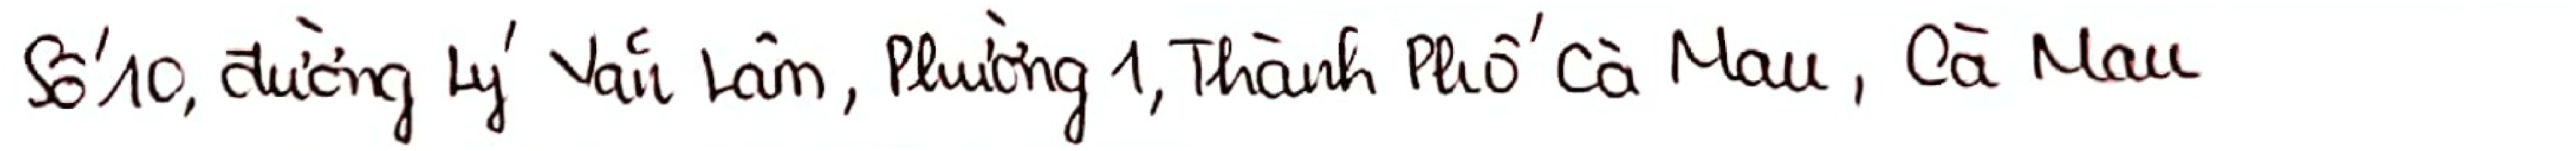

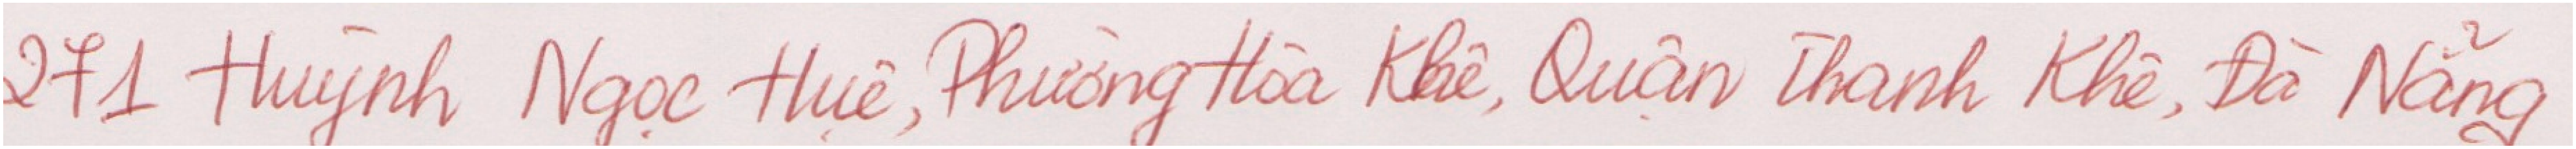

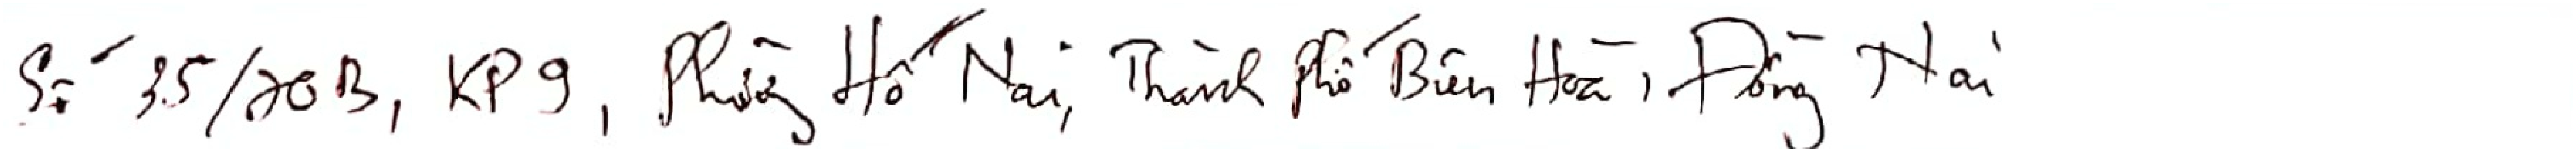

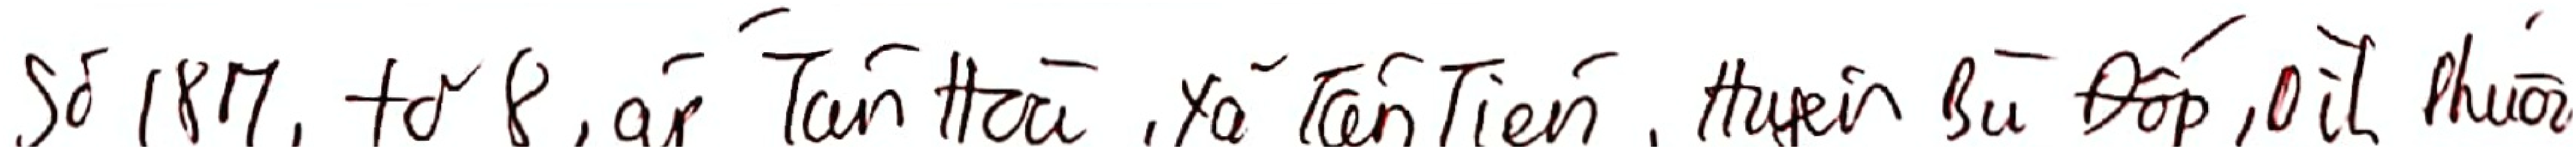

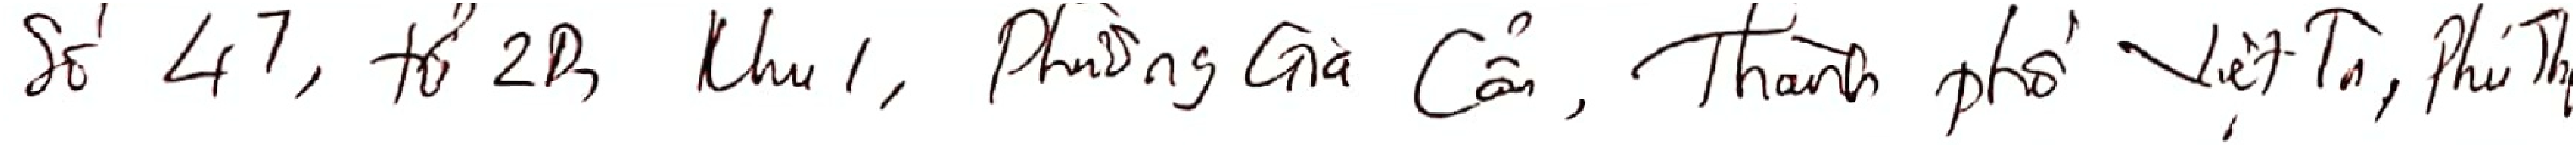

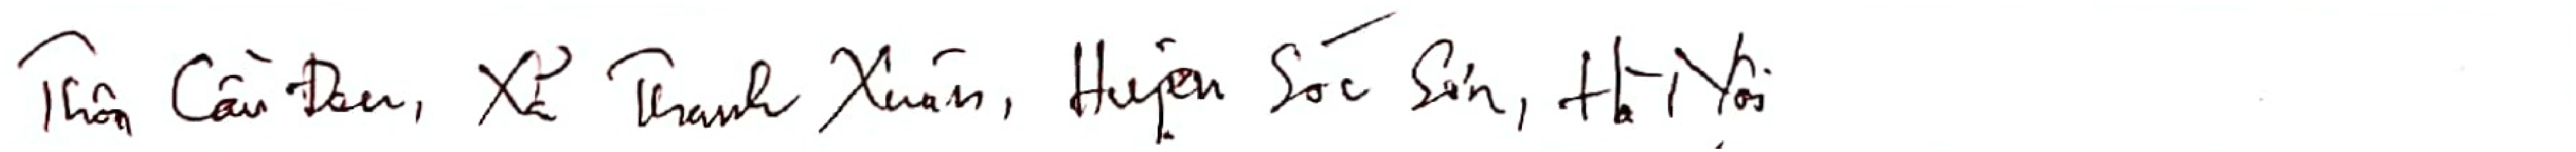

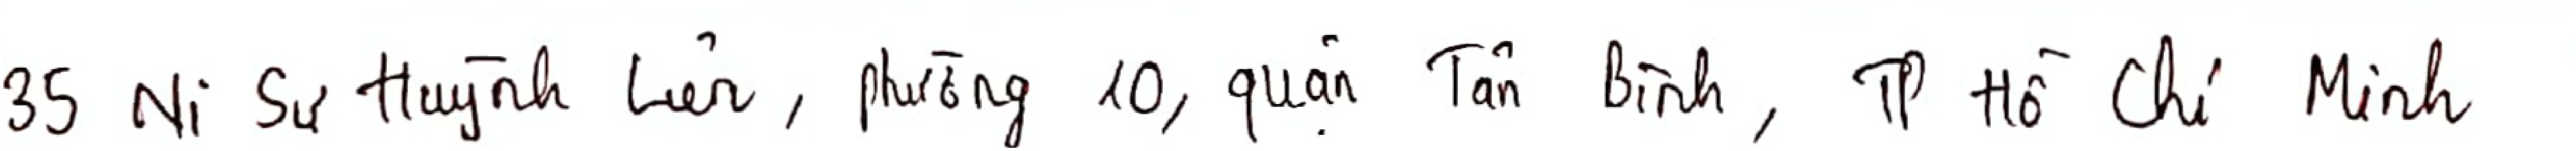

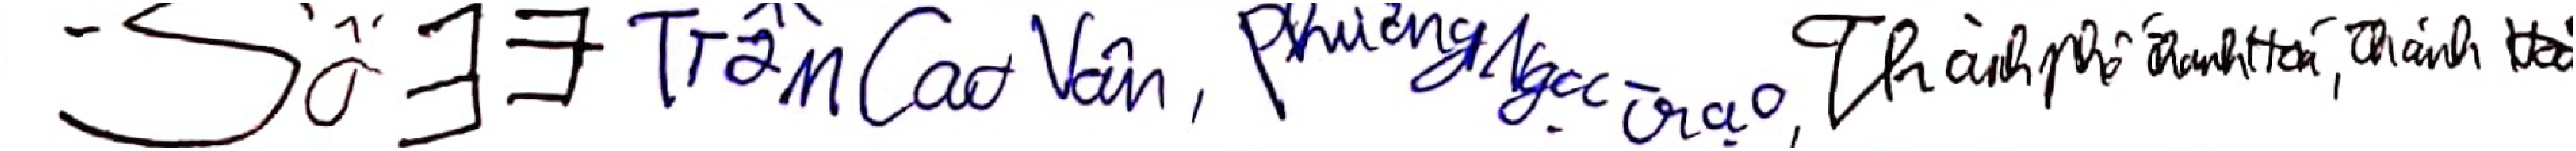

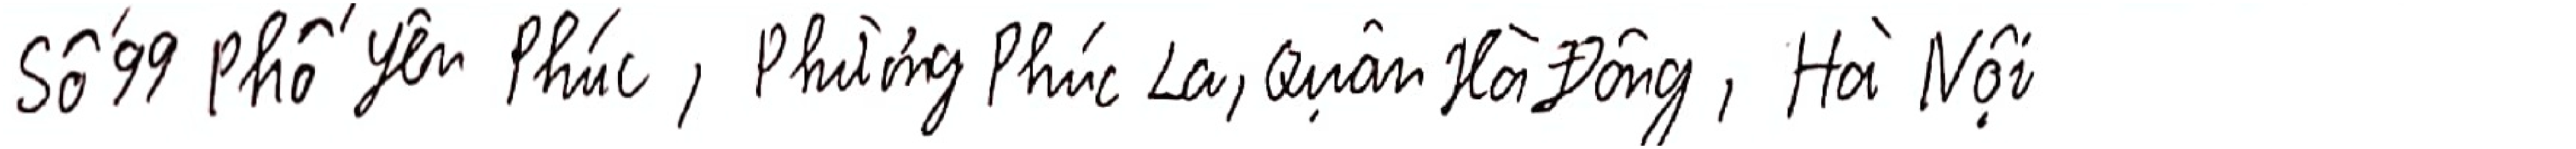

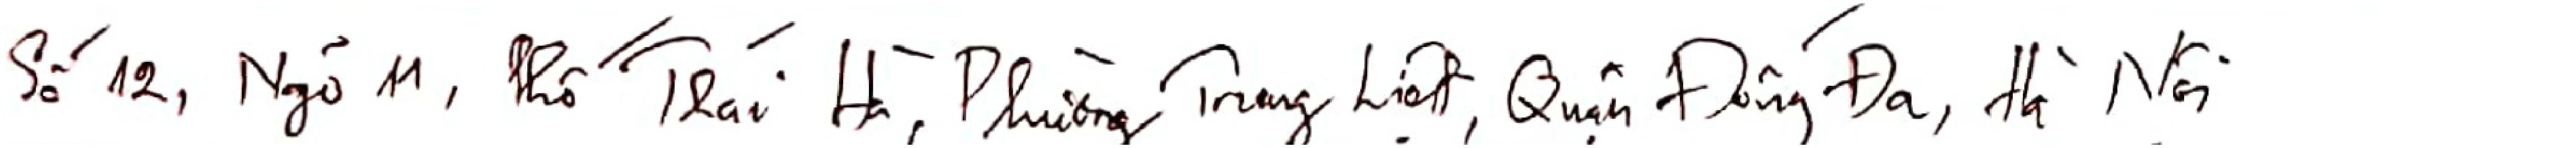

In [137]:
for i in range(len(predictions[:10])):
    show_batch(test_image_paths[i])
    print(predictions[i])

# ALL LOWWER JUST TEST CODE

In [31]:
from contextlib import redirect_stdout
from tensorflow.keras import backend as K
from tensorflow.keras import Model

from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import MaxNorm


from tensorflow.keras.layers import Conv2D, Bidirectional, LSTM, GRU, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, PReLU
from tensorflow.keras.layers import Input, Add, Activation, Lambda, MaxPooling2D, Reshape

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [33]:
callbacks = [
        ModelCheckpoint(
            filepath=filepath,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            verbose=1),
        EarlyStopping(
            monitor="val_loss",
            min_delta=1e-8,
            patience=20,
            restore_best_weights=True,
            verbose=1),
        ReduceLROnPlateau(
            monitor="val_loss",
            min_delta=1e-8,
            factor=0.2,
            patience=10,
            verbose=1)
    ]

In [39]:
input_data = Input(name="input", shape=(128,2000,1))

cnn = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding="same")(input_data)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.01)(cnn)
cnn = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(cnn)

cnn = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.01)(cnn)
cnn = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(cnn)

cnn = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.01)(cnn)
cnn = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(cnn)

cnn = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.01)(cnn)
cnn = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding="valid")(cnn)

cnn = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.01)(cnn)
cnn = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding="valid")(cnn)

cnn = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.01)(cnn)
cnn = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding="valid")(cnn)

cnn = Dropout(rate=0.2)(cnn)
cnn = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.01)(cnn)
cnn = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding="valid")(cnn)

cnn = Dropout(rate=0.2)(cnn)
cnn = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.01)(cnn)

cnn = Dropout(rate=0.2)(cnn)
cnn = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
cnn = BatchNormalization()(cnn)
cnn = LeakyReLU(alpha=0.01)(cnn)

shape = cnn.get_shape()
blstm = Reshape((shape[1], shape[2] * shape[3]))(cnn)

blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)

blstm = Dropout(rate=0.5)(blstm)
output_data = Dense(148, activation="softmax")(blstm)

In [40]:
act_model = Model(input_data, output_data)
act_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 2000, 1)]    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 2000, 16)     160       
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 2000, 16)     64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 2000, 16)     0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 1000, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 1000, 16)      2320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 1000, 16)      64  

In [43]:
model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1:0", shape=(None, 128, 2000, 1), dtype=float32) at layer "input_1". The following previous layers were accessed without issue: []

In [ ]:
check=[]
for i in train_image_paths:
    check.append(cv2.imread(str(i)))
for i in test_image_paths:
    check.append(cv2.imread(str(i)))

In [ ]:
h_max = 0
w_max = 0
for i in range(len(check)):
    print(type(check[i]))
    h,w,_ = check[i].shape
    if h > h_max:
        h_max = h
    if w > w_max:
        w_max = w

In [ ]:
h_max

In [ ]:
w_max

In [ ]:
# hist = cv2.calcHist([edged[0]], [0], None, [256], [0,256])
# plt.figure()
# plt.title("Grayscale Histogram")
# plt.xlabel("Bins")
# plt.ylabel("# of pixels")
# plt.plot(hist)
# plt.xlim([0,256])
# plt.show()

In [ ]:
def deskew(image, width):
    (h, w) = image.shape[:2]

    # find the SKEW = tangle(theta)
    moments = cv2.moments(image)
    skew = moments['mu11'] / moments['mu02']

    # YOUR PART: affine transformation (double check the cheat sheet yesterday)
    M = np.float32([[1, skew, 0],
                    [0, 1, 0]])
    
    # YOUR PART: make it straight with warpAffine
    image = cv2.warpAffine(image, M, (w, h))
    # resize the width to be exact size
    image = imutils.resize(image, width=width)

    return image

def center_extent(image, size):
    (eW, eH) = size

    # if horizontal size is longer
    if image.shape[1] > image.shape[0]:
        # resize it to be eW
        image = imutils.resize(image, width=eW)
    else:
        # if vertical size is longer
        # resize it to be eH
        image = imutils.resize(image, height=eH)

    # our new extended canvas
    extent = np.zeros((eH, eW), dtype='uint8')
    
    # calculate the offsetX and offsetY of old image to new canvas
    offsetX = (eW - image.shape[1]) // 2
    offsetY = (eH - image.shape[0]) // 2

    # make sure the old image is in the middle of the canvas
    extent[offsetY:offsetY + image.shape[0], offsetX:offsetX+image.shape[1]] = image

    # find the middle of digit
    CM = mahotas.center_of_mass(extent)
    (cY, cX) = np.round(CM).astype("int32")

    # find the displacement distance of that middle of the digit to the middle of the canvas
    (dX, dY) = ((size[0]//2) - cX, (size[1] // 2) - cY)

    # move the digit to be totally in the middle of the canvas
    M = np.float32([[1, 0, dX], [0, 1, dY]])
    extent = cv2.warpAffine(extent, M, size)

    return extent

In [ ]:
copy = edged[0].copy()
cv2.drawContours(copy, cnts[0], -1, (240, 0, 159), 2)
show(copy)

In [ ]:
show(edged[0])

In [ ]:
len(cnts[0])

In [ ]:
copy = edged[0].copy()
cv2.drawContours(copy, cnts[0], 8, (240, 0, 159), 5)
show(copy)

In [ ]:
a = deskew(edged[4],2664)

In [ ]:
show(a)

In [ ]:
copy = edged[4].copy()
contour, _ = cv2.findContours(copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
len(contour)

In [ ]:
blank = np.zeros((copy.shape[0], copy.shape[1], 3))
new_contour = []
for c in contour:
    if cv2.contourArea(c) > 100:
        new_contour.append(c)
len(new_contour)

In [ ]:
cv2.drawContours(blank, new_contour, -1, (0,255,0), 3)

In [ ]:
plt.imshow(blank)

In [ ]:
blank.shape

In [ ]:
print('á')

In [ ]:
cont0 = np.asarray(cnts[0])

In [ ]:
import re
import cv2
import html
import string
import numpy as np
import numba as nb


def adjust_to_see(img):
    """Rotate and transpose to image visualize (cv2 method or jupyter notebook)"""

    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -90, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    img = cv2.warpAffine(img, M, (nW + 1, nH + 1))
    img = cv2.warpAffine(img.transpose(), M, (nW, nH))

    return img


def augmentation(imgs,
                 rotation_range=0,
                 scale_range=0,
                 height_shift_range=0,
                 width_shift_range=0,
                 dilate_range=1,
                 erode_range=1):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    imgs = imgs.astype(np.float32)
    _, h, w = imgs.shape

    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    for i in range(len(imgs)):
        imgs[i] = cv2.warpAffine(imgs[i], affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
        imgs[i] = cv2.erode(imgs[i], erode_kernel, iterations=1)
        imgs[i] = cv2.dilate(imgs[i], dilate_kernel, iterations=1)

    return imgs


def normalization(imgs):
    """Normalize list of images"""

    imgs = np.asarray(imgs).astype(np.float32)
    _, h, w = imgs.shape

    for i in range(len(imgs)):
        m, s = cv2.meanStdDev(imgs[i])
        imgs[i] = imgs[i] - m[0][0]
        imgs[i] = imgs[i] / s[0][0] if s[0][0] > 0 else imgs[i]

    return np.expand_dims(imgs, axis=-1)


"""
Preprocess metodology based in:
    H. Scheidl, S. Fiel and R. Sablatnig,
    Word Beam Search: A Connectionist Temporal Classification Decoding Algorithm, in
    16th International Conference on Frontiers in Handwriting Recognition, pp. 256-258, 2018.
"""


def preprocess_save(path, input_size, dir_):
    """Make the process with the `input_size` to the scale resize"""
    try:
        if isinstance(path, str):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        if isinstance(path, tuple):
            image, boundbox = img
            img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

            for i in range(len(boundbox)):
                if isinstance(boundbox[i], float):
                    total = len(img) if i < 2 else len(img[0])
                    boundbox[i] = int(total * boundbox[i])

            img = np.asarray(img[boundbox[0]:boundbox[1], boundbox[2]:boundbox[3]], dtype=np.uint8)

        ht, wt, _ = input_size
        h, w = np.asarray(img).shape
        f = max((w / wt), (h / ht))

        new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
        img = cv2.resize(img, new_size)

        _, binary = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)

    #     if np.sum(img) * 0.8 > np.sum(binary):
    #         img = illumination_compensation(img)

        img = remove_cursive_style(img)

    #     target = np.ones([ht, wt], dtype=np.uint8) * 255
    #     target[0:new_size[1], 0:new_size[0]] = img
    #     img = cv2.transpose(target)
        img = Image.fromarray(img)
        img.save(dir_+str(path).split('\\')[-1])

        return img
    except:
        pass

"""
Illumination Compensation based in:
    K.-N. Chen, C.-H. Chen, C.-C. Chang,
    Efficient illumination compensation techniques for text images, in
    Digital Signal Processing, 22(5), pp. 726-733, 2012.
"""


def illumination_compensation(img):
    """Illumination compensation technique for text image"""

    def scale(img):
        s = np.max(img) - np.min(img)
        res = img / s
        res -= np.min(res)
        res *= 255
        return res

    img = img.astype(np.float32)
    height, width = img.shape
    sqrt_hw = np.sqrt(height * width)

    bins = np.arange(0, 300, 10)
    bins[26] = 255
    hp = np.histogram(img, bins)
    for i in range(len(hp[0])):
        if hp[0][i] > sqrt_hw:
            hr = i * 10
            break

    np.seterr(divide='ignore', invalid='ignore')
    cei = (img - (hr + 50 * 0.3)) * 2
    cei[cei > 255] = 255
    cei[cei < 0] = 0

    m1 = np.asarray([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape((3, 3))
    m2 = np.asarray([-2, -1, 0, -1, 0, 1, 0, 1, 2]).reshape((3, 3))
    m3 = np.asarray([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape((3, 3))
    m4 = np.asarray([0, 1, 2, -1, 0, 1, -2, -1, 0]).reshape((3, 3))

    eg1 = np.abs(cv2.filter2D(img, -1, m1))
    eg2 = np.abs(cv2.filter2D(img, -1, m2))
    eg3 = np.abs(cv2.filter2D(img, -1, m3))
    eg4 = np.abs(cv2.filter2D(img, -1, m4))

    eg_avg = scale((eg1 + eg2 + eg3 + eg4) / 4)

    h, w = eg_avg.shape
    eg_bin = np.zeros((h, w))
    eg_bin[eg_avg >= 30] = 255

    h, w = cei.shape
    cei_bin = np.zeros((h, w))
    cei_bin[cei >= 60] = 255

    h, w = eg_bin.shape
    tli = 255 * np.ones((h, w))
    tli[eg_bin == 255] = 0
    tli[cei_bin == 255] = 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(tli, kernel, iterations=1)
    int_img = np.asarray(cei)

    estimate_light_distribution(width, height, erosion, cei, int_img)

    mean_filter = 1 / 121 * np.ones((11, 11), np.uint8)
    ldi = cv2.filter2D(scale(int_img), -1, mean_filter)

    result = np.divide(cei, ldi) * 260
    result[erosion != 0] *= 1.5
    result[result < 0] = 0
    result[result > 255] = 255

    return np.asarray(result, dtype=np.uint8)


@nb.jit(nopython=True)
def estimate_light_distribution(width, height, erosion, cei, int_img):
    """Light distribution performed by numba (thanks @Sundrops)"""

    for y in range(width):
        for x in range(height):
            if erosion[x][y] == 0:
                i = x

                while i < erosion.shape[0] and erosion[i][y] == 0:
                    i += 1

                end = i - 1
                n = end - x + 1

                if n <= 30:
                    h, e = [], []

                    for k in range(5):
                        if x - k >= 0:
                            h.append(cei[x - k][y])

                        if end + k < cei.shape[0]:
                            e.append(cei[end + k][y])

                    mpv_h, mpv_e = max(h), max(e)

                    for m in range(n):
                        int_img[x + m][y] = mpv_h + (m + 1) * ((mpv_e - mpv_h) / n)

                x = end
                break


"""
Deslating image process based in,
    A. Vinciarelli and J. Luettin,
    A New Normalization Technique for Cursive Handwritten Wrods, in
    Pattern Recognition, 22, 2001.
"""


def remove_cursive_style(img):
    """Remove cursive writing style from image with deslanting algorithm"""

    def calc_y_alpha(vec):
        indices = np.where(vec > 0)[0]
        h_alpha = len(indices)

        if h_alpha > 0:
            delta_y_alpha = indices[h_alpha - 1] - indices[0] + 1

            if h_alpha == delta_y_alpha:
                return h_alpha * h_alpha
        return 0

    alpha_vals = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
    rows, cols = img.shape
    results = []

    ret, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = otsu if ret < 127 else sauvola(img, (int(img.shape[0] / 2), int(img.shape[0] / 2)), 127, 1e-2)

    for alpha in alpha_vals:
        shift_x = max(-alpha * rows, 0.)
        size = (cols + int(np.ceil(abs(alpha * rows))), rows)
        transform = np.asarray([[1, alpha, shift_x], [0, 1, 0]], dtype=np.float)

        shear_img = cv2.warpAffine(binary, transform, size, cv2.INTER_NEAREST)
        sum_alpha = 0
        sum_alpha += np.apply_along_axis(calc_y_alpha, 0, shear_img)
        results.append([np.sum(sum_alpha), size, transform])

    result = sorted(results, key=lambda x: x[0], reverse=True)[0]
    warp = cv2.warpAffine(img, result[2], result[1], borderValue=255)

    return cv2.resize(warp, dsize=(cols, rows))


"""
Sauvola binarization based in,
    J. Sauvola, T. Seppanen, S. Haapakoski, M. Pietikainen,
    Adaptive Document Binarization, in IEEE Computer Society Washington, 1997.
"""


def sauvola(img, window, thresh, k):
    """Sauvola binarization"""

    rows, cols = img.shape
    pad = int(np.floor(window[0] / 2))
    sum2, sqsum = cv2.integral2(
        cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT))

    isum = sum2[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sum2[0:rows, 0:cols] - \
        sum2[window[0]:rows + window[0], 0:cols] - \
        sum2[0:rows, window[1]:cols + window[1]]

    isqsum = sqsum[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sqsum[0:rows, 0:cols] - \
        sqsum[window[0]:rows + window[0], 0:cols] - \
        sqsum[0:rows, window[1]:cols + window[1]]

    ksize = window[0] * window[1]
    mean = isum / ksize
    std = (((isqsum / ksize) - (mean**2) / ksize) / ksize) ** 0.5
    threshold = (mean * (1 + k * (std / thresh - 1))) * (mean >= 100)

    return np.asarray(255 * (img >= threshold), 'uint8')


"""
DeepSpell based text cleaning process.
    Tal Weiss.
    Deep Spelling.
    Medium: https://machinelearnings.co/deep-spelling-9ffef96a24f6#.2c9pu8nlm
    Github: https://github.com/MajorTal/DeepSpell
"""

RE_DASH_FILTER = re.compile(r'[\-\˗\֊\‐\‑\‒\–\—\⁻\₋\−\﹣\－]', re.UNICODE)
RE_APOSTROPHE_FILTER = re.compile(r'&#39;|[ʼ՚＇‘’‛❛❜ߴߵ`‵´ˊˋ{}{}{}{}{}{}{}{}{}]'.format(
    chr(768), chr(769), chr(832), chr(833), chr(2387),
    chr(5151), chr(5152), chr(65344), chr(8242)), re.UNICODE)
RE_RESERVED_CHAR_FILTER = re.compile(r'[¶¤«»]', re.UNICODE)
RE_LEFT_PARENTH_FILTER = re.compile(r'[\(\[\{\⁽\₍\❨\❪\﹙\（]', re.UNICODE)
RE_RIGHT_PARENTH_FILTER = re.compile(r'[\)\]\}\⁾\₎\❩\❫\﹚\）]', re.UNICODE)
RE_BASIC_CLEANER = re.compile(r'[^\w\s{}]'.format(re.escape(string.punctuation)), re.UNICODE)

LEFT_PUNCTUATION_FILTER = """!%&),.:;<=>?@\\]^_`|}~"""
RIGHT_PUNCTUATION_FILTER = """"(/<=>@[\\^_`{|~"""
NORMALIZE_WHITESPACE_REGEX = re.compile(r'[^\S\n]+', re.UNICODE)


def text_standardize(text):
    """Organize/add spaces around punctuation marks"""

    if text is None:
        return ""

    text = html.unescape(text).replace("\\n", "").replace("\\t", "")

    text = RE_RESERVED_CHAR_FILTER.sub("", text)
    text = RE_DASH_FILTER.sub("-", text)
    text = RE_APOSTROPHE_FILTER.sub("'", text)
    text = RE_LEFT_PARENTH_FILTER.sub("(", text)
    text = RE_RIGHT_PARENTH_FILTER.sub(")", text)
    text = RE_BASIC_CLEANER.sub("", text)

    text = text.lstrip(LEFT_PUNCTUATION_FILTER)
    text = text.rstrip(RIGHT_PUNCTUATION_FILTER)
    text = text.translate(str.maketrans({c: f" {c} " for c in string.punctuation}))
    text = NORMALIZE_WHITESPACE_REGEX.sub(" ", text.strip())

    return text


def generate_multigrams(sentence):
    """
    Generate n-grams of the sentence.
    i.e.:
    original sentence: I like code .
        > sentence 1 : I like
        > sentence 2 : I like code .
        > sentence 3 : like
        > sentence 4 : like code .
        > sentence 5 : code .
    """

    tokens = sentence.split()
    tk_length = len(tokens)
    multigrams = []

    for y in range(tk_length):
        new_sentence = True
        support_text = ""

        for x in range(y, tk_length):
            if y == 0 and tk_length > 2 and x == (tk_length - 1):
                continue

            if len(tokens[x]) <= 2 and tokens[x] != tokens[-1]:
                support_text += f" {tokens[x]}"
                continue

            last = ""
            if x > y and len(multigrams) > 0 and not new_sentence:
                last = multigrams[-1]

            multigrams.append(f"{last}{support_text} {tokens[x]}".strip())
            new_sentence = False
            support_text = ""

    return multigrams


In [ ]:
for i in train_image_paths:
    preprocess_save(str(i),(32,128,1),"../week8_project/HTR/data_flo/train/")

In [ ]:
for i in test_image_paths:
    preprocess_save(str(i),(32,128,1),"../week8_project/HTR/data_flo/test/")

In [ ]:
show(a)

In [ ]:
a.shape

In [ ]:
show(cv2.imread(str(train_image_paths[0])))